In [58]:
from symbol import yield_arg

from meteostat import Point, Daily
import pandas as pd
from datetime import datetime

from sklearn.preprocessing import MinMaxScaler

# Define LA
uci = Point(33.6405, -117.8443) # Latitude, Longitude of uci

# Get daily data from 2015 to 2023
start = datetime(2015, 1, 1)
end = datetime(2023, 12, 31)

data = Daily(uci, start, end)
data = data.fetch()
print(data.head())

               tavg    tmin     tmax    prcp  snow  wdir    wspd  wpgt  \
time                                                                     
2015-01-01 10.20000 4.40000 15.60000 0.00000   NaN   NaN 4.50000   NaN   
2015-01-02 11.00000 5.60000 16.10000 0.00000   NaN   NaN 3.20000   NaN   
2015-01-03 12.10000 6.70000 17.20000 0.00000   NaN   NaN 3.10000   NaN   
2015-01-04 13.00000 6.10000 21.10000 0.00000   NaN   NaN 1.90000   NaN   
2015-01-05 16.40000 8.30000 26.10000 0.00000   NaN   NaN 1.60000   NaN   

                 pres  tsun  
time                         
2015-01-01 1019.80000   NaN  
2015-01-02 1020.10000   NaN  
2015-01-03 1023.30000   NaN  
2015-01-04 1025.40000   NaN  
2015-01-05 1022.20000   NaN  


In [59]:
print(data.shape)
print(data.count())

(3287, 10)
tavg    3287
tmin    3287
tmax    3287
prcp    3287
snow    1099
wdir    2126
wspd    3287
wpgt       0
pres    3286
tsun       0
dtype: int64


In [60]:
data['snow'].fillna(0, inplace=True)
data['wpgt'].fillna(0, inplace=True)
data['tsun'].fillna(0, inplace=True)
data['pres'].fillna(0, inplace=True)
data['wdir'] = data['wdir'].interpolate(method='linear').fillna(method='bfill')


In [61]:
data['day_of_year']=data.index.dayofyear
data['month']=data.index.month
data['season']=(data['month']%12)//3

data['temp_range'] = data['tmax'] - data['tmin']

data['is_rainy'] = (data['prcp']>0).astype(int)
data['is_snowy'] = (data['snow']>0).astype(int)
print(data.head())
print(data.isnull().sum())

               tavg    tmin     tmax    prcp    snow     wdir    wspd    wpgt  \
time                                                                            
2015-01-01 10.20000 4.40000 15.60000 0.00000 0.00000 45.00000 4.50000 0.00000   
2015-01-02 11.00000 5.60000 16.10000 0.00000 0.00000 45.00000 3.20000 0.00000   
2015-01-03 12.10000 6.70000 17.20000 0.00000 0.00000 45.00000 3.10000 0.00000   
2015-01-04 13.00000 6.10000 21.10000 0.00000 0.00000 45.00000 1.90000 0.00000   
2015-01-05 16.40000 8.30000 26.10000 0.00000 0.00000 45.00000 1.60000 0.00000   

                 pres    tsun  day_of_year  month  season  temp_range  \
time                                                                    
2015-01-01 1019.80000 0.00000            1      1       0    11.20000   
2015-01-02 1020.10000 0.00000            2      1       0    10.50000   
2015-01-03 1023.30000 0.00000            3      1       0    10.50000   
2015-01-04 1025.40000 0.00000            4      1       0    15.000

In [72]:
features = ['tavg','tmin','tmax','prcp', 'snow', 'wdir', 'wspd', 'wpgt', 'pres', 'tsun', 
            'day_of_year', 'season', 'temp_range', 'is_rainy', 'is_snowy']
target = ['tavg']
dataset = data[features+target]

from sklearn.preprocessing import MinMaxScaler
import numpy as np
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(dataset)

def create_dataset(data, look_back=30):
    X,y = [],[]
    for i in range(len(data)-look_back-1):
        X.append(data[i:(i+look_back), :-1])
        y.append(data[i+look_back, -1])
    return np.array(X), np.array(y)
X,y = create_dataset(scaled_data)

In [73]:
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=False
)

X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

from torch.utils.data import DataLoader, TensorDataset

train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [74]:
class LSTM(nn.Module):
    def __init__(self, inputsize, hiddensize, num_layers, outputsize):
        super(LSTM, self).__init__()
        self.hiddensize = hiddensize
        self.num_layers = num_layers
        
        self.lstm  =  nn.LSTM(inputsize, hiddensize, num_layers, batch_first=True)
        self.fc = nn.Linear(hiddensize, outputsize)
        
    def forward(self, x):
        h0=torch.zeros(self.num_layers, x.size(0), self.hiddensize).to(x.device)
        c0=torch.zeros(self.num_layers, x.size(0), self.hiddensize).to(x.device)
        
        out, _ = self.lstm(x, (h0, c0))
        
        out = self.fc(out[:, -1, :])
        return out

imput_size = len(features)
hidden_size = 128
num_layers = 2
output_size = 1

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model=LSTM(inputsize=imput_size, hiddensize=hidden_size, num_layers=num_layers, outputsize=output_size).to(device)
print(model)

LSTM(
  (lstm): LSTM(15, 128, num_layers=2, batch_first=True)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)


In [75]:
from torch import optim

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 50
train_losses = []
test_losses = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for batch_x, batch_y in train_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * batch_x.size(0)
    
    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)
    
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for batch_x, batch_y in test_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            outputs = model(batch_x)
            test_loss += criterion(outputs, batch_y).item() * batch_x.size(0)
            
    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
    
    if (epoch + 1) % 5 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], '
              f'Train Loss: {train_loss:.6f}, Test Loss: {test_loss:.6f}')

Epoch [5/50], Train Loss: 0.005708, Test Loss: 0.004189
Epoch [10/50], Train Loss: 0.003719, Test Loss: 0.003400
Epoch [15/50], Train Loss: 0.003044, Test Loss: 0.002368
Epoch [20/50], Train Loss: 0.002992, Test Loss: 0.002315
Epoch [25/50], Train Loss: 0.002949, Test Loss: 0.002338
Epoch [30/50], Train Loss: 0.002931, Test Loss: 0.002217
Epoch [35/50], Train Loss: 0.002930, Test Loss: 0.002242
Epoch [40/50], Train Loss: 0.002859, Test Loss: 0.002262
Epoch [45/50], Train Loss: 0.002769, Test Loss: 0.002456
Epoch [50/50], Train Loss: 0.002770, Test Loss: 0.002285


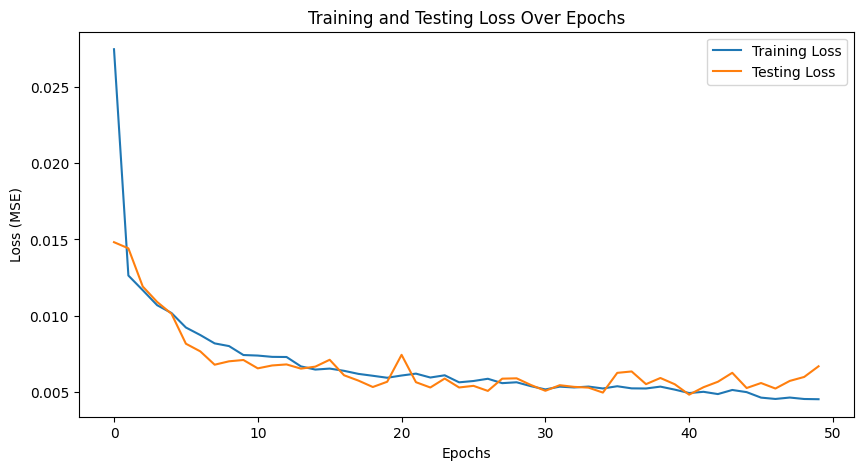

In [67]:
from matplotlib import pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Testing Loss')
plt.title('Training and Testing Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.show()

In [76]:
model.eval()
with torch.no_grad():
    test_predictions = model(X_test.to(device)).cpu().numpy()
    
    temp_array = np.zeros((len(y_test), len(features) + 1))
    temp_array[:, -1] = test_predictions.flatten()
    
    test_predictions = scaler.inverse_transform(temp_array)[:, -1]
    
    temp_array[:, -1] = y_test.flatten()
    y_test_actual = scaler.inverse_transform(temp_array)[:, -1]

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mae = mean_absolute_error(y_test_actual, test_predictions)
rmse = np.sqrt(mean_squared_error(y_test_actual, test_predictions))
r2 = r2_score(y_test_actual, test_predictions)

print(f'Test MAE: {mae:.2f}')
print(f'Test RMSE: {rmse:.2f}')
print(f'Test R²: {r2:.4f}')

Test MAE: 0.88
Test RMSE: 1.19
Test R²: 0.9068


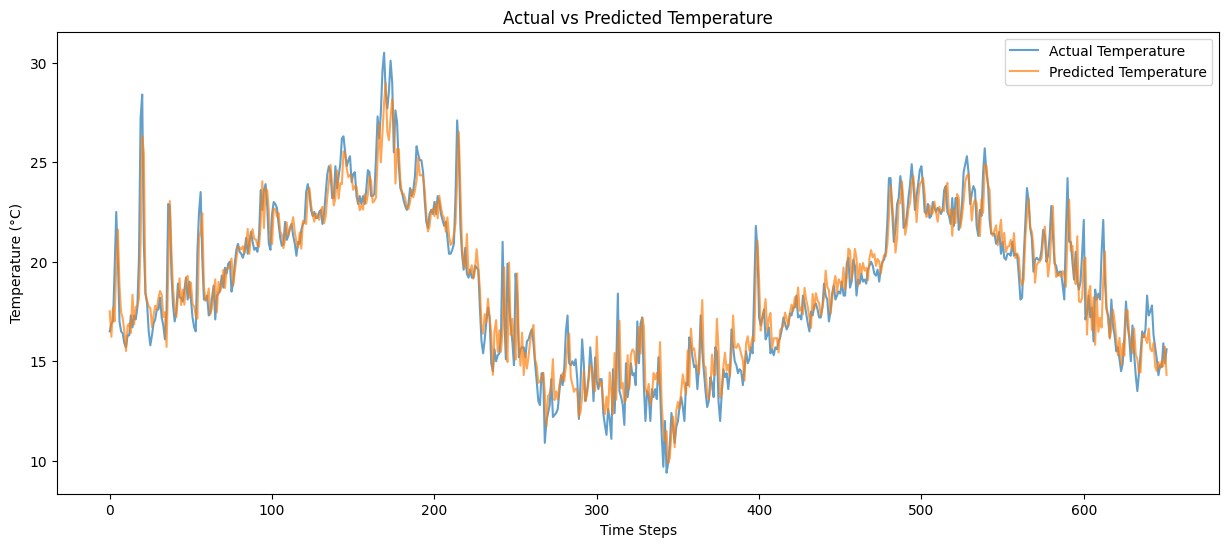

In [77]:
plt.figure(figsize=(15, 6))
plt.plot(y_test_actual, label='Actual Temperature', alpha=0.7)
plt.plot(test_predictions, label='Predicted Temperature', alpha=0.7)
plt.title('Actual vs Predicted Temperature')
plt.xlabel('Time Steps')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.show()

In [78]:
torch.save(model.state_dict(), 'weather_lstm_model.pth')